In [1]:
import glob
import cv2
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import resample
from scipy.optimize import curve_fit
import skimage.filters as filters
from collections import deque
from math import ceil
from IPython.display import Image
from moviepy.editor import VideoFileClip
%matplotlib inline
warped_size = np.array([1280, 720])
global left_fit
global right_fit

OFFSET =0

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#CALIBRATION OF CAMERA--NOT DONE
#TOP VIEW--DONE
#THRESHOLDING--DONE
#EXTRACT PIXEL INFO -- DONE
#POLYFIT AND VALIDATE--NOT DONE [ONE LANE ATLEAST]
#SEARCH FROM PRIOR --DONE
#CURVATURE --DONE **NEEDS TO BE CALIBRATED**
#FIT ON IMAGE--DONE
#UNWARP--DONE

In [3]:
#TOP VIEW
def topview(image):
    if len(image.shape)==2:
        height,width = image.shape
        src = np.array([[0,0],[width,0],[width,height],[0,height]],dtype='float32')
        dest = np.array([[0,0],[width,0],[width,479],[210,height]],dtype='float32')
        h=cv2.getPerspectiveTransform(src,dest)
        inv=cv2.getPerspectiveTransform(dest,src)
        imgd = np.zeros((height,width),dtype='uint8')
        imgd = cv2.warpPerspective(image, h, (width,height))
    else:
        height,width,col = image.shape
        src = np.array([[0,0],[width,0],[width,height],[0,height]],dtype='float32')
        dest = np.array([[0,0],[width,0],[width,479],[210,height]],dtype='float32')
        h, status = cv2.findHomography(src, dest)
        inv,status=cv2.findHomography(dest,src)
        imgd = np.zeros((height,width,col),dtype='uint8')
        imgd[:,:,0] = cv2.warpPerspective(image[:,:,0], h, (width,height))
        imgd[:,:,1] = cv2.warpPerspective(image[:,:,1], h, (width,height))
        imgd[:,:,2] = cv2.warpPerspective(image[:,:,2], h, (width,height))
    return imgd,h,inv

In [4]:
#THRESHOLDING
def threshold(image):
    kernel = 5
    image = cv2.GaussianBlur(image,(kernel, kernel),0)
    red_chan=image[:,:,0]
    thres=(200,255)
    output=np.zeros_like(red_chan)
    th, dst = cv2.threshold(red_chan, 200, 255, cv2.THRESH_BINARY);
    th, binary_warped = cv2.threshold(dst, 220, 255, cv2.THRESH_BINARY)
    return binary_warped

In [5]:
#TRIAL 1
# Extract Pixels from Image 
def func1(img):
    case=0
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img,img,img))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if not leftx_base and not rightx_base:
        case=2
        return case
    elif not leftx_base and len(rightx_base)!=0:
        case=-1
    elif not rightx_base and len(leftx_base)!=0:
        case=1
    else:
        case=0
    nwindows = 9
    margin = 50
    minpix = 20
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    countl=0
    countr=0
    if case==1 or case==0:
        for window in range(nwindows):
            countl=countl+1
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
        #win_xright_low = rightx_current - margin
        #win_xright_high = rightx_current + margin
        
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        #good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
            left_lane_inds.append(good_left_inds)
        #right_lane_inds.append(good_right_inds)
        
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            else:    
                break
        #if len(good_right_inds) > minpix:        
           # rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
       # else:
          #  break
    if case==-1 or case==0:
        for window in range(nwindows):
            countr=countr+1
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
        #win_xleft_low = leftx_current - margin
        #win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
        
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        #left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        
        #if len(good_left_inds) > minpix:
        #    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        #else:    
        #    break
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            else:
                break



    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    print(type(leftx))
    print(leftx.shape)
    print(case)
    
    return leftx, lefty, rightx, righty, out_img,countl,countr,window_height



In [6]:
def compute_left():
    for window in range(nwindows):
        count=count+1
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #win_xright_low = rightx_current - margin
        #win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        #good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        left_lane_inds.append(good_left_inds)
        #right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        else:    
            break
        #if len(good_right_inds) > minpix:        
           # rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
       # else:
          #  break
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img,count,window_height
    

In [7]:

   
'''
   nwindows =9
   margin = 50
    minpix = 20
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    countl=0
    countr=0''' 
    

    

'\n   nwindows =9\n   margin = 50\n    minpix = 20\n    window_height = np.int(img.shape[0]//nwindows)\n    nonzero = img.nonzero()\n    nonzeroy = np.array(nonzero[0])\n    nonzerox = np.array(nonzero[1])\n    leftx_current = leftx_base\n    rightx_current = rightx_base\n    left_lane_inds = []\n    right_lane_inds = []\n    countl=0\n    countr=0'

In [8]:
#POLYFIT
def fit_polynomial(img):
    leftx, lefty, rightx, righty, out_img,cl,cr,h = func1(img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty1 = np.linspace(img.shape[0],img.shape[0]-(cl*h),img.shape[0]) 
    ploty2 = np.linspace(img.shape[0],img.shape[0]-(cr*h),img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty1**2 + left_fit[1]*ploty1 + left_fit[2]
        right_fitx = right_fit[0]*ploty2**2 + right_fit[1]*ploty2 + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty1**2 + 1*ploty1
        right_fitx = 1*ploty2**2 + 1*ploty2

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty1, color='yellow')
    plt.plot(right_fitx, ploty2, color='yellow')

    return out_img,left_fit,right_fit,cl,cr,h

def search_around_poly(binary_warped,left_fit,right_fit):
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    lcurv,rcurv=measure_curvature_pixels(left_fit,right_fit,ploty)
    return result,lcurv,rcurv,left_fit,right_fit


'''plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    '''  
    

"plt.plot(left_fitx, ploty, color='yellow')\n    plt.plot(right_fitx, ploty, color='yellow')\n    "

<class 'numpy.ndarray'>
(6951,)
0


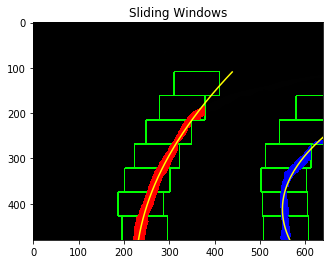

In [9]:
#DRIVER CODE
im=cv2.imread("frame74.jpg")
comb=np.copy(im)
cv2.imshow("image",im)
cv2.waitKey(0)
height,width,_ = im.shape
im,h,inv = topview(im)
cv2.imshow("image",im)
threshwarp=threshold(im)
#im.save
out_img,left,right,cl,cr,h = fit_polynomial(threshwarp)
plt.imshow(out_img)
plt.title('Sliding Windows')
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [11]:
def measure_curvature_pixels(left_fit,right_fit,ploty):
    ym_per_pix = 3.048/100 #GENERALIZE
    xm_per_pix = 3.7/378 #GENERALIZE
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

Left curvature :1672.7764123498298
Right curvature :3773.3304713575913


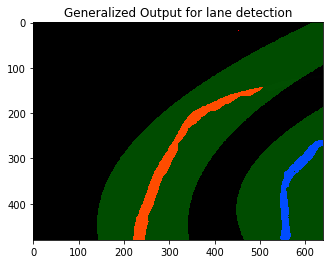

In [12]:
result,lcurv,rcurv,lf,rf=search_around_poly(threshwarp,left,right)
plt.title('Generalized Output for lane detection')
plt.imshow(result)
print("Left curvature :",end="")
print(lcurv)
print("Right curvature :",end="")
print(rcurv)

In [13]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv,n_windl,n_windr,height):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty1 = np.linspace(h,h-(n_windl*height-1), num=h)# to cover same y-range as image4
    ploty2 = np.linspace(h,h-(n_windr*height), num=h)
    left_fitx = l_fit[0]*ploty1**2 + l_fit[1]*ploty1 + l_fit[2]
    right_fitx = r_fit[0]*ploty2**2 + r_fit[1]*ploty2 + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty1]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty2])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,0, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp,1, 0)
    return result
print('...')

...


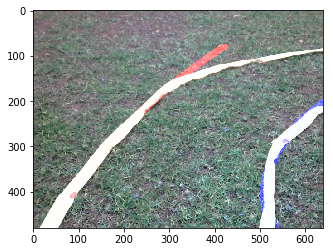

In [14]:
final=draw_lane(comb,threshwarp,lf,rf,inv,cl,cr,h)
plt.imshow(final)

In [ ]:
#VIDEO PROCESSING 
#1.PIPELINE
def process_video(img):
    comb=np.copy(im)
    count=0
    height,width,_ = im.shape
    im,h,inv = topview(im)
    threshwarp=threshold(im)
    if count==0:
        out_img,lf,rf = fit_polynomial(threshwarp) #sliding windows    
        count=1
    else:
        result,lcurv,rcurv,lf,rf=search_around_poly(threshwarp,lf,rf)
        count+=1
        if count==5:
            count=0
    final=draw_lane(comb,threshwarp,lf,rf,inv)
    return final